In [59]:
import numpy as np
import Bio
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
import matplotlib.pyplot as plt
import math

1

Но до сих пор нет оптимального метода предсказания третичной структуры белка.Большинство методов занимают много времени. В основном из-за большого разрыва между вычислительными возможностями и временем в миллисекундах сворачивания белка алгоритмы предсказания не настолько эффективны как экспериментальные исследования: ядерно-магнитный резонанс (ЯМР), cryo-EM (электронная микроскопия) и рентгеноструктурный анализ кристаллов белка.

Есть достаточно известный хабравчанам самый общий подход, называемый «молекулярная динамика» и подходящий для любых молекул и систем. Берем развернутый белок, приписываем всем атомам случайные значения скоростей, считаем взаимодействия между атомами, повторяем до тех пор, пока система не придет в стабильное состояние, соответствующее свернутому белку. Почему это не работает? Потому что современные вычислительные мощности позволяют за месяцы работы кластера считать десятки наносекунд для системы из тысяч атомов, какой является белок, помещенный в воду. Время же сворачивания белка – миллисекунды и больше, то есть вычислительных мощностей не хватает, разрыв – в несколько порядков. Впрочем, пару лет назад американцы совершили некоторый прорыв. Они использовали специальное железо, оптимизированное для векторных вычислений и после оптимизации на аппаратном уровне у них за месяцы работы машины получилось посчитать молдинамику до миллисекунд для очень маленького белка и белок свернулся, структура соответствовала экспериментально определенной ( http://en.wikipedia.org/wiki/Anton_(computer) )! Однако праздновать победу еще рано. Они взяли очень маленький (его размер раз в 5-10 меньше среднего белка) и один из самых быстросворачивающихся белков, классический модельный белок, на котором изучалось сворачивание. Для больших белков время расчетов увеличивается нелинейно и потребуются уже годы, то есть еще есть над чем работать.

Другой подход реализован в Rosetta. Они разбивают последовательность белка на очень короткие (3-9 остатков) фрагменты и смотрят, какие конформации для этих фрагментов присутствуют в PDB, после чего запускают Монте-Карло по всем вариантам и смотрят, что получится. Иногда получается что-то годное, но в моих случаях через несколько дней работы кластера получаешь такой бублик, что возникает немой вопрос: «Кто писал их оценочную функцию, ставящую какую-то хорошую оценку вот этой загогулине?».

Есть инструменты и для моделирования вручную – можно предсказать вторичную структуру и попробовать вручную крутить ее, находя лучшую укладку

2

В последовательности есть страрт и стоп кадоны, мы можем их найти и определить начло и конец

# Task 1

In [36]:

def vyravnivanie(s1, s2):
    len_s1 = len(s1)+1
    len_s2 = len(s2)+1
    d = np.zeros( (len_s1, len_s2)) 
    d[0][0] = 0
    for i_a in range(1,len_s1):
        d[i_a][0]=-i_a
    for i_b in range(1,len_s2):
        d[0][i_b]=-i_b
    for i_a in range(1,len_s1):
        for i_b in range(1,len_s2):    
            d[i_a][i_b]=max(d[i_a-1][i_b]-1, d[i_a][i_b-1]-1, d[i_a-1][i_b-1]+ (1 if s1[i_a-1]==s2[i_b-1]else(-1)) )
    print(d)
    wage=d[len_s1-1][len_s2-1]
    len_s1=len_s1-1
    len_s2=len_s2-1
    
    res1=""
    res2=""
    while len_s1!=0 or len_s2!=0:
        
        if (d[len_s1-1][len_s2-1]>=max(d[len_s1-1][len_s2],d[len_s1][len_s2-1])):
            len_s1=len_s1-1
            len_s2=len_s2-1
            res1=s1[len_s1]+res1
            res2=s2[len_s2]+res2
            
        elif (d[len_s1-1][len_s2] >=max(d[len_s1-1][len_s2-1],d[len_s1][len_s2-1])):
            len_s2=len_s2-1
            res1=s1[len_s2]+res1
            res2="-"+res2
          
        else:
            res1="-"+res1
            len_s2=len_s2-1
            res2=s2[len_s2]+res2
            
    print(res1+"\n"+res2)

In [38]:
vyravnivanie("CAGCGTGG","CAGCACTTGGATTCTCGG")

[[  0.  -1.  -2.  -3.  -4.  -5.  -6.  -7.  -8.  -9. -10. -11. -12. -13.
  -14. -15. -16. -17. -18.]
 [ -1.   1.   0.  -1.  -2.  -3.  -4.  -5.  -6.  -7.  -8.  -9. -10. -11.
  -12. -13. -14. -15. -16.]
 [ -2.   0.   2.   1.   0.  -1.  -2.  -3.  -4.  -5.  -6.  -7.  -8.  -9.
  -10. -11. -12. -13. -14.]
 [ -3.  -1.   1.   3.   2.   1.   0.  -1.  -2.  -3.  -4.  -5.  -6.  -7.
   -8.  -9. -10. -11. -12.]
 [ -4.  -2.   0.   2.   4.   3.   2.   1.   0.  -1.  -2.  -3.  -4.  -5.
   -6.  -7.  -8.  -9. -10.]
 [ -5.  -3.  -1.   1.   3.   3.   2.   1.   0.   1.   0.  -1.  -2.  -3.
   -4.  -5.  -6.  -7.  -8.]
 [ -6.  -4.  -2.   0.   2.   2.   2.   3.   2.   1.   0.  -1.   0.  -1.
   -2.  -3.  -4.  -5.  -6.]
 [ -7.  -5.  -3.  -1.   1.   1.   1.   2.   2.   3.   2.   1.   0.  -1.
   -2.  -3.  -4.  -3.  -4.]
 [ -8.  -6.  -4.  -2.   0.   0.   0.   1.   1.   3.   4.   3.   2.   1.
    0.  -1.  -2.  -3.  -2.]]
CAGC----G--T----GG
CAGCACTTGGATTCTCGG


# TASK 3


In [3]:
from Bio import SeqIO

records = SeqIO.parse("cl.fq", "fastq")
count = SeqIO.write(records, "out.fasta", "fasta")
print("Converted %i records" % count)

Converted 250 records


# Task 4

In [6]:
#5’-GGATCGTAGCCTA-3’.
dna = Seq("GGATCGTAGCCTA", generic_dna)
print("3'-"+str(dna.complement()+"-5'"))

3'-CCTAGCATCGGAT-5'


# Task5

In [61]:
str1="GCTAGTCAGATCTGACGCTA"
str2="GATGGTCACATCTGCCGC--"

In [67]:

def f(str1, str2):
    points1=[]
    points2=[]
    for i in range(len(str1)):
        if(str2[i]!='-'):
            points2.append(i)
            if str1[i]==str2[i]:
                points1.append(i)
            else:
                u=i
                while u<len(str1):
                    if str1[i]==str2[u]:
                        break
                    else:
                        u+=1

                d=i
                while d>=0:
                    if str1[i]==str2[d]:
                        break
                    else:
                        d-=1

                print(u,d)
                if u!=len(str1) and d!=-1:
                    if(u-i>i-d):
                        points1.append(d)
                    else:
                        points1.append(u)

                else:
                    if u!=len(str1): 
                        points1.append(u)
                    if d!=-1: 
                        points1.append(d)   

    plt.figure(figsize=(7,7))        
    plt.plot([0,20],[0,20]) 


    plt.scatter(points1,points2)

6 -1
7 1
13 4
20 9


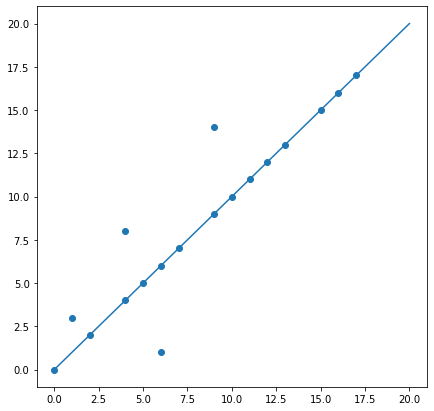

In [68]:
f(str1,str2)

# Task6



Во вором штраф за пропуски был меньше, поэтому их больше

# Task 13
